# Policy sweep plotting (minimal)

Goal: Load epoch-level aggregates and produce per-learning-rate plots for a chosen policy class.
- X axis: epoch
- Y axis: mean reward (per-epoch average across trajectories)
- One trace per (policy_class, run_id) within each learning-rate facet

This cleaned-up notebook imports small helpers and focuses on the end result: per-learning-rate plots.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from utils.plot_utils import (
    load_epoch_agg_multi,
    filter_epoch_df,
    extract_fields,
    plot_epoch_rewards,
)

In [2]:
'''
Specify one or more result directories to load.

i.e. directory passed to --output-dir when running experiments.
Assumed to store epoch_agg__*.parquet files in subdirectories.
'''

DATA_DIRS = [
    # "results/grid_sweep_top/parquet",
    # "results/grid_sweep_middle/parquet",
    # "results/grid_sweep_bottom/parquet",
    # "results/grid_sweep_failed_pairs/parquet",
    "results/all_policies_smoke_test/sweep_20250925-102752/parquet",
]

In [3]:
# Load all epoch aggregate parquet files from one or more directories

df = load_epoch_agg_multi(DATA_DIRS)
if df.empty:
    print(f"No parquet files found under: {DATA_DIRS}")
else:
    display(df.head())
    print('Rows:', len(df))

,run_id,config_hash,label,setup,seed,num_days,num_trajs,num_epochs,epoch,agent_name,policy_class,policy_params_json,mean_reward,std_reward,n_trajs,source_dir
0,00e3b764-45be-4032-be8b-c648b72deefc,504f7a133cc6847ca7ee1cb5dad068f3a54f9d228fba19...,base_config-i33,setup_1,123,1,200,100,0,learner,AC_TD_Gaussian_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""learning_rate""...",-28.170471,35.078750,200,results/all_policies_smoke_test/sweep_20250925...
1,00e3b764-45be-4032-be8b-c648b72deefc,504f7a133cc6847ca7ee1cb5dad068f3a54f9d228fba19...,base_config-i33,setup_1,123,1,200,100,0,baseline,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",2.075000,2.463610,200,results/all_policies_smoke_test/sweep_20250925...
2,00e3b764-45be-4032-be8b-c648b72deefc,504f7a133cc6847ca7ee1cb5dad068f3a54f9d228fba19...,base_config-i33,setup_1,123,1,200,100,1,learner,AC_TD_Gaussian_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""learning_rate""...",-29.311618,38.190439,200,results/all_policies_smoke_test/sweep_20250925...
3,00e3b764-45be-4032-be8b-c648b72deefc,504f7a133cc6847ca7ee1cb5dad068f3a54f9d228fba19...,base_config-i33,setup_1,123,1,200,100,1,baseline,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",2.425000,2.498875,200,results/all_policies_smoke_test/sweep_20250925...
4,00e3b764-45be-4032-be8b-c648b72deefc,504f7a133cc6847ca7ee1cb5dad068f3a54f9d228fba19...,base_config-i33,setup_1,123,1,200,100,2,learner,AC_TD_Gaussian_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""learning_rate""...",-28.854092,36.816398,200,results/all_policies_smoke_test/sweep_20250925...


Rows: 15350


In [4]:
# # Loading shareable results, instead.
# df = pd.read_parquet("shareable_results/setup_1_days_1/")

In [5]:
df[(df["epoch"] == 2999) & (df["mean_reward"] > 1)]

,run_id,config_hash,label,setup,seed,num_days,num_trajs,num_epochs,epoch,agent_name,policy_class,policy_params_json,mean_reward,std_reward,n_trajs,source_dir


In [6]:
# setup_1_days_1_df = df[(df['setup'] == 'setup_1') & (df['num_days'] == 1)]

# setup_1_days_1_df = extract_fields(
#     setup_1_days_1_df,
#     nested_column="policy_params_json",
#     fields="learning_rate",
#     new_column_name="learning_rate",
# )

# setup_1_days_1_df.sample(5)

In [7]:
# _temp = setup_1_days_1_df.groupby(["setup", "num_days", "policy_class", "learning_rate"])["run_id"].nunique().reset_index()
# _temp = _temp.pivot_table(index=["setup", "num_days", "policy_class"], columns="learning_rate", values="run_id", fill_value=0)

# display(_temp)

In [8]:
# setup_1_days_1_df.to_parquet('results/setup_1_days_1_all_policies.parquet', index=False, compression='snappy')


Setup: setup_1 | Agent: None | Label prefix: None
Learning rates found: [5e-07, 5e-06]


/app/utils/plot_utils.py:718: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


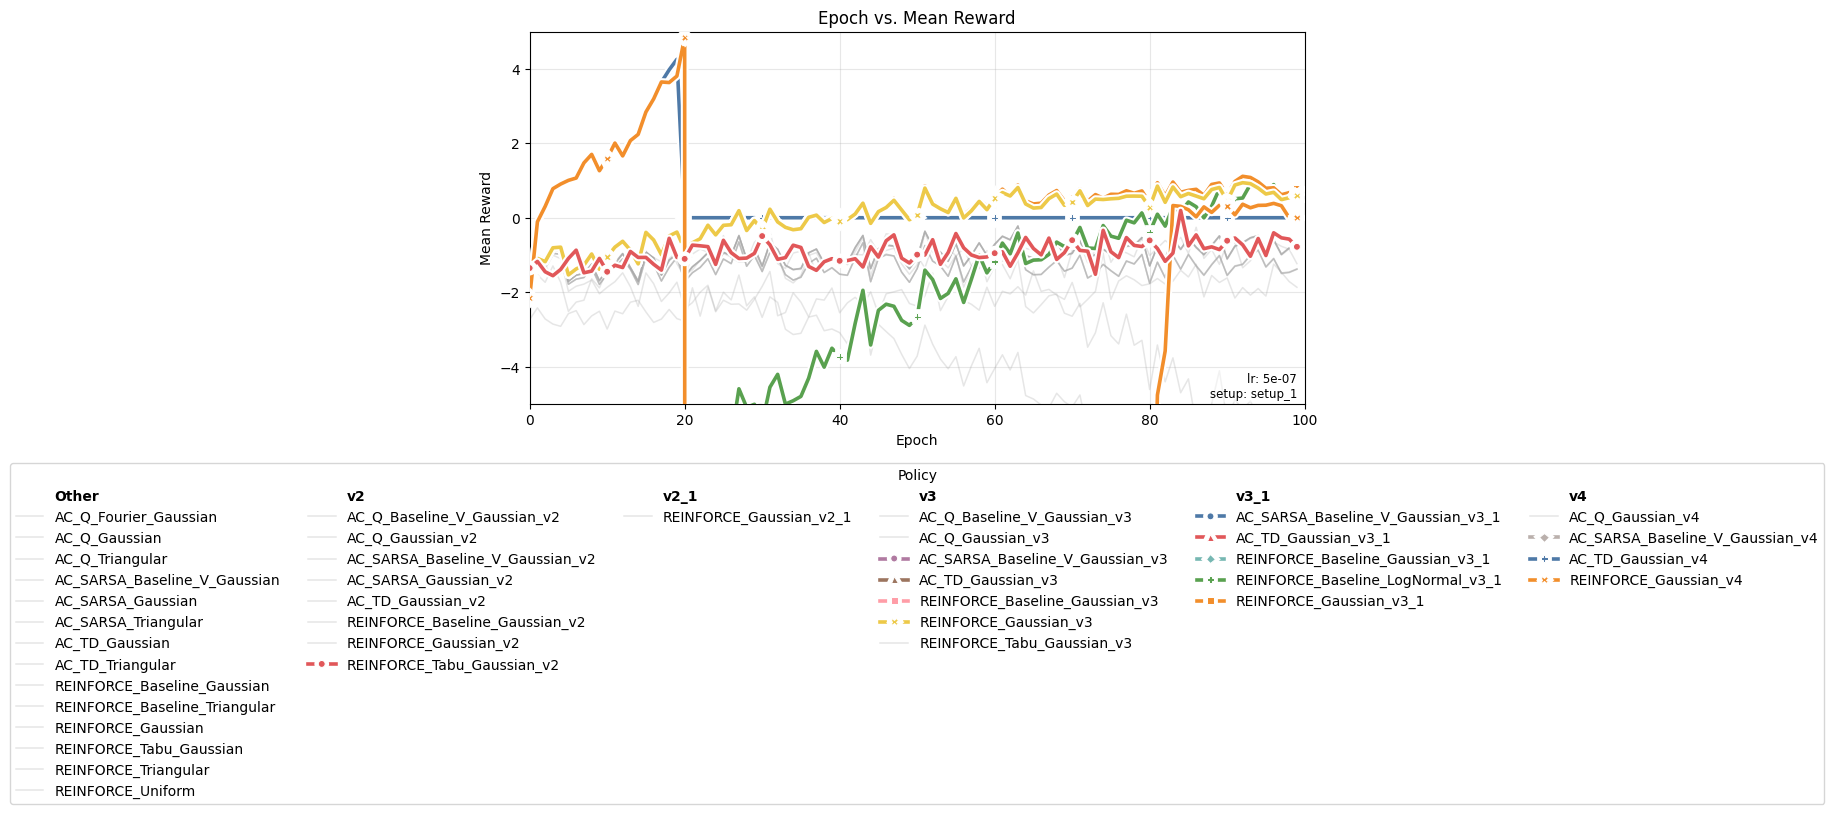

/app/utils/plot_utils.py:718: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


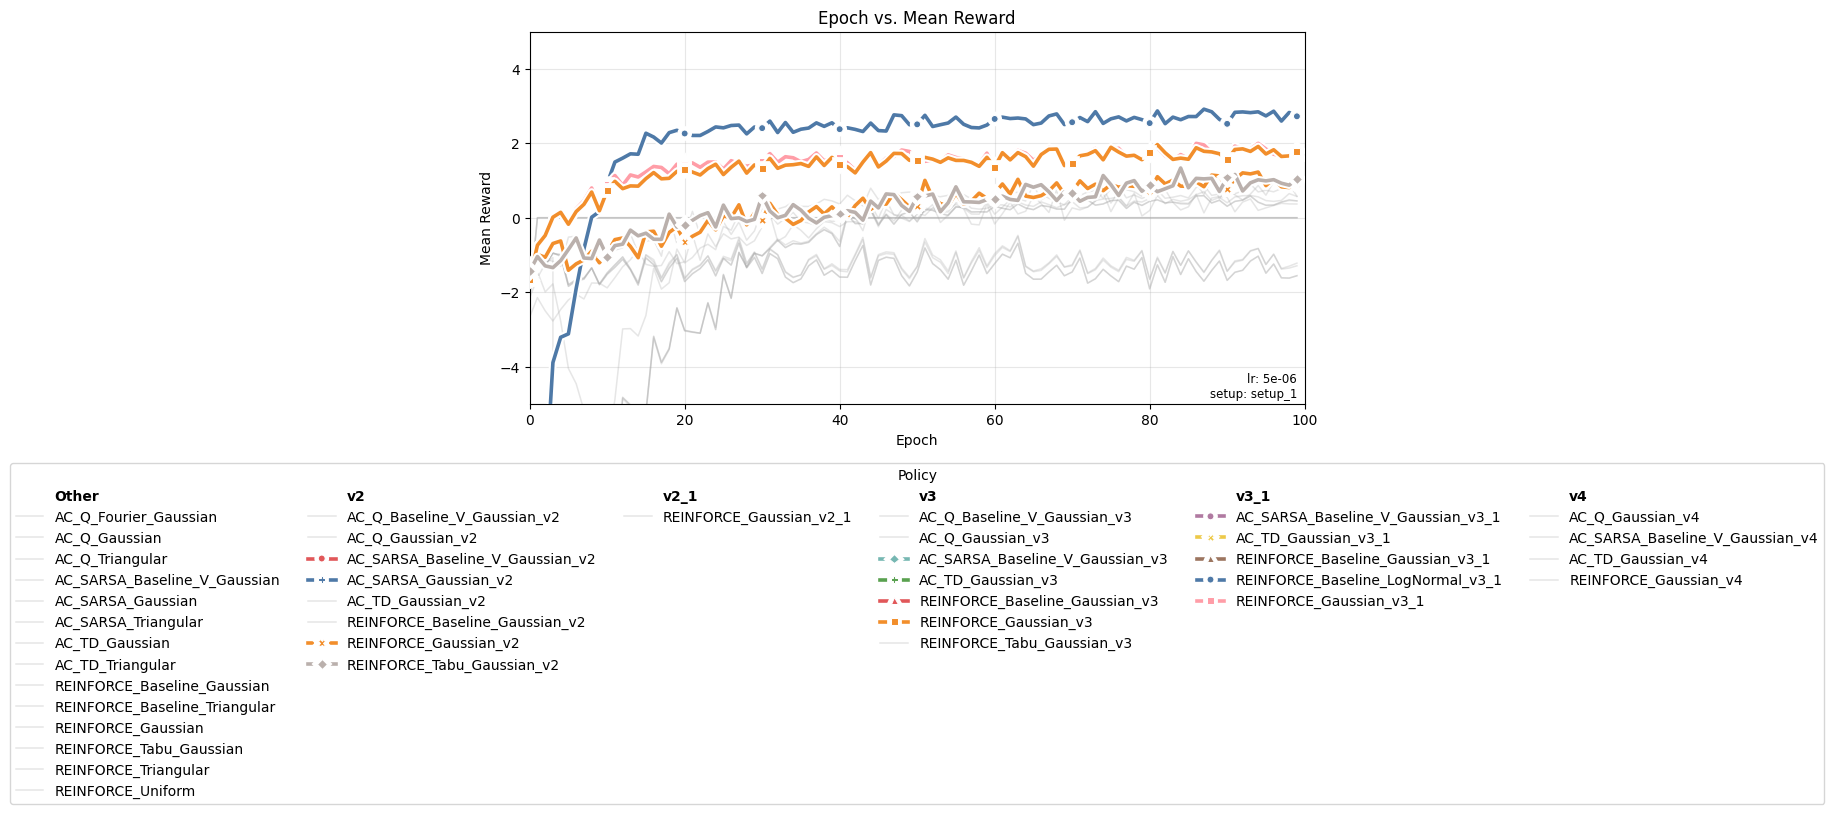

In [12]:
# Extract learning_rate into its own column and plot, grouped by learning rate (all policies)
setup = "setup_1"           # e.g., 'setup_1'
agent_name = None      # e.g., 'agent1'
label = None           # e.g., 'grid_sweep_top' (prefix match)

# Extract the learning_rate field into its own column
filtered = extract_fields(
    df,
    nested_column="policy_params_json",
    fields="learning_rate",
    new_column_name="learning_rate",
)

# Apply filters (setup/agent exact), and label as a prefix filter
base = filter_epoch_df(filtered, setup=setup, agent_name=agent_name, label=None)
if label is not None and 'label' in base.columns:
    base = base[base['label'].astype(str).str.startswith(label, na=False)]

# List the unique learning rates present after filtering
vals = sorted(v for v in base['learning_rate'].unique() if pd.notna(v))
print('Setup:', setup, '| Agent:', agent_name, '| Label prefix:', label)
print('Learning rates found:', vals)

# Plot one figure per learning rate (all policies included in each plot)
for lr in vals:
    sub = base[base['learning_rate'] == lr]
    if sub.empty:
        print("Warning: No data for learning_rate =", lr)
        continue
    fig, ax = plot_epoch_rewards(
        sub,
        title="Epoch vs. Mean Reward",
        x_min=0,
        x_max=100,
        y_min=-5,
        y_max=5,
        plot_every_epoch=1,
        top_k_marker_every_epoch=10,
        top_k=13,
        top_k_markers=True,
        top_k_marker_size=5,
        outline_width=3.0,
        top_k_linestyles=('-', '-', '-'),
        palette='tab10',
        # Group legend entries by version extracted from policy names (e.g., v2, v3_1, v4) and place groups side-by-side
        legend_group_regex=r"(v\d+(?:_\d+)?)",
        legend_position="bottom",
        legend_group_side_by_side=True,
        # Minimal metadata box (opt-in): show learning rate and setup
        show_metadata=True,
        metadata_keys=("learning_rate", "setup"),
        metadata_loc='bottom-right',
        metadata_fontsize=8.5,
        metadata_box_alpha=0.5,
    )
    display(fig)
    plt.close(fig)

In [ ]:
# Build a sorted table of last-epoch mean rewards per (policy_class, run_id) and include policy_params_json
from utils.plot_utils import last_epoch_table

if 'base' in globals() and not base.empty:
    table = last_epoch_table(
        df,
        group_cols=("policy_class", "run_id"),
        epoch_col="epoch",
        value_col="mean_reward",
        sort_desc=True,
        extra_cols=("policy_params_json",),
    )
    display(table)
else:
    print("No data in 'base' to summarize.")

In [ ]:
table[
    (table["last_epoch_mean_reward"] > -1) & 
    (table["last_epoch_mean_reward"] < 1) & 
    (table["policy_class"] != "FixedBidPolicy")
]